<a href="https://colab.research.google.com/github/DaeSeokSong/LSTM-PPoA/blob/main/Predict_Price_of_Agricultural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 참조문헌
## [A Prediction Model for Agricultural Products Price with LSTM Network](https://www.koreascience.or.kr/article/JAKO201809469053682.page)

**신성호, 이미경, 송사광**

한국과학기술정보연구원 연구데이터플랫폼센터,
한국과학기술정보연구원 연구데이터플랫폼센터/과학기술연합대학원대학교 빅데이터과학과

Sungho Shin(maximus74@kisti.re.kr), Mikyoung Lee(jerryis@kisti.re.kr),
Sa-kwang Song(esmallj@kisti.re.kr)


---
---



# 당년 농산물 가격 예측 LSTM 모델

Input = 1~저번 달까지의 pram 값을 하나로 묶은 array(인스턴스)

output = 당월의 해당 채소 가격

layer = 원래 해당 채소 가격

### Google Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/DeepLearning/Project/PPoA
!ls -al

Mounted at /content/gdrive
/content/gdrive/MyDrive/DeepLearning/Project/PPoA
total 828
drwx------ 2 root root   4096 Nov 24 06:07  Dataset
-rw------- 1 root root 696712 Nov 29 03:24  PPoA.h5
-rw------- 1 root root 145992 Nov 29 04:58 'Predict Price of Agricultural.ipynb'


### Import


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import metrics, losses
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Sequential, load_model
from keras.layers import LSTM, Bidirectional, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Function

In [21]:
# 정규화
def Normalization(targetData) :
    return (targetData - targetData.min()) / (targetData.max() - targetData.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def Denormalization_min(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)

    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()
def Denormalization_max(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)

    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.max()
def Denormalization_avg(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)

    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + ((org_x_np.min() + org_x_np.max()) / 2)

### Global variable

In [4]:
TARGET_YEAR = 2020
START_YEAR = 0
END_YEAR = 0
CROPS = ''

### Data read

##### Trained data

In [5]:
START_YEAR = 2006
END_YEAR = 2019
CROPS = 'onion'
dataset = []

# 지난 최대 5년간 최대, 최소치를 기준으로 정규화해야 하는 항목들
df = pd.read_csv('./Dataset/'+CROPS+'/last_production_'+CROPS+'.csv', index_col=0, encoding='cp949')
# 전년 재배면적
last_cultiv_area = df['전년면적']
# 전년 평균 생산량(수확량)
last_production = df['전년생산량']
# 전년 평균 생산단수
last_prod_unit = df['전년단수']
last_prams = [last_cultiv_area,                    # 전년 재배면적
            last_production,                       # 전년 평균 생산량
            last_prod_unit                         # 전년 평균 생산단수
            ]

for next in range(0, (END_YEAR-START_YEAR)+1) :
    cur_year = START_YEAR + next

    f_name = str(cur_year)+'_'+CROPS+'.csv'
    df = pd.read_csv('./Dataset/'+CROPS+'/'+f_name, index_col=0)

    ''' 기상변수 '''
    # 강수량
    precipi_avg = df['평균월강수량(mm)']
    precipi_max = df['최다월강수량(mm)']
    # 기온
    temper_avg = df['평균기온(℃)']
    temper_max = df['평균최고기온(℃)']
    temper_min = df['평균최저기온(℃)']
    # 풍속
    windSpeed_avg = df['평균풍속(m/s)']
    windSpeed_max = df['최대풍속(m/s)']
    # 습도
    humidity_avg = df['평균습도(%rh)']
    humidity_min = df['최저습도(%rh)']
    # 일조량 / 일사량
    sunshine = df['일조합']
    insolation = df['일사합']

    ''' 기타변수 '''
    # 전년 수입량
    last_amount_import = df['전년수입량']
    # 해당 농작물 가격 (index == 12)
    crops_price = df['가격']
    # 경유 가격
    diesel_price = df['경유가격']
    # 물가지수(price index -> pidx), 2015년 기준 얼마나 오르고 내렸는지
    total_pidx = df['총물가지수']
    prod_pidx = df['상품']
    agricul_marine_prod_pidx = df['농축수산물']
    indust_prod_pidx = df['공업제품']
    serv_pidx = df['서비스']
    pub_serv_pidx = df['공공서비스']
    per_serv_pidx = df['개인서비스']
    house_pidx = df['집세']

    # 정규화 해야하는 데이터셋
    prams = [precipi_avg, precipi_max,             # 강수량
            temper_avg, temper_max, temper_min,    # 기온
            windSpeed_avg, windSpeed_max,          # 풍속
            humidity_avg, humidity_min,            # 습도
            sunshine,                              # 일조량
            insolation,                            # 일사량
            crops_price,                           # 해당 농작물 월별 가격
            diesel_price,                          # 월별 경유 가격
            last_amount_import,                    # 전년 수입량
            # 물가지수
            total_pidx, prod_pidx, agricul_marine_prod_pidx, indust_prod_pidx, serv_pidx, pub_serv_pidx, per_serv_pidx, house_pidx,
            ]

    dataset.append(prams)

##### Predicted data

In [6]:
CROPS = 'onion'
pred_dataset = []

# 지난 최대 5년간 최대, 최소치를 기준으로 정규화해야 하는 항목들
df = pd.read_csv('./Dataset/'+CROPS+'/last_production_'+CROPS+'.csv', index_col=0, encoding='cp949')
# 전년 재배면적
last_cultiv_area = df['전년면적']
# 전년 평균 생산량(수확량)
last_production = df['전년생산량']
# 전년 평균 생산단수
last_prod_unit = df['전년단수']
pred_last_prams = [last_cultiv_area,                    # 전년 재배면적
            last_production,                       # 전년 평균 생산량
            last_prod_unit                         # 전년 평균 생산단수
            ]

f_name = str(TARGET_YEAR)+'_'+CROPS+'.csv'
df = pd.read_csv('./Dataset/'+CROPS+'/'+f_name, index_col=0)

''' 기상변수 '''
# 강수량
precipi_avg = df['평균월강수량(mm)']
precipi_max = df['최다월강수량(mm)']
# 기온
temper_avg = df['평균기온(℃)']
temper_max = df['평균최고기온(℃)']
temper_min = df['평균최저기온(℃)']
# 풍속
windSpeed_avg = df['평균풍속(m/s)']
windSpeed_max = df['최대풍속(m/s)']
# 습도
humidity_avg = df['평균습도(%rh)']
humidity_min = df['최저습도(%rh)']
# 일조량 / 일사량
sunshine = df['일조합']
insolation = df['일사합']

''' 기타변수 '''
# 전년 수입량
last_amount_import = df['전년수입량']
# 해당 농작물 가격 (index == 12)
crops_price = df['가격']
# 경유 가격
diesel_price = df['경유가격']
# 물가지수(price index -> pidx), 2015년 기준 얼마나 오르고 내렸는지
total_pidx = df['총물가지수']
prod_pidx = df['상품']
agricul_marine_prod_pidx = df['농축수산물']
indust_prod_pidx = df['공업제품']
serv_pidx = df['서비스']
pub_serv_pidx = df['공공서비스']
per_serv_pidx = df['개인서비스']
house_pidx = df['집세']

# 정규화 해야하는 데이터셋
pred_prams = [precipi_avg, precipi_max,             # 강수량
        temper_avg, temper_max, temper_min,    # 기온
        windSpeed_avg, windSpeed_max,          # 풍속
        humidity_avg, humidity_min,            # 습도
        sunshine,                              # 일조량
        insolation,                            # 일사량
        crops_price,                           # 해당 농작물 월별 가격
        diesel_price,                          # 월별 경유 가격
        last_amount_import,                    # 전년 수입량
        # 물가지수
        total_pidx, prod_pidx, agricul_marine_prod_pidx, indust_prod_pidx, serv_pidx, pub_serv_pidx, per_serv_pidx, house_pidx,
        ]

pred_dataset.append(pred_prams)

### Data preprocessing

##### Trained data

In [7]:
''' 정규화 '''
# last_prams
norm_last = []
for idx, pram in enumerate(last_prams) :
    tmp_last = []
    for next in range(0, (END_YEAR-START_YEAR)+1) :
        tmp_df = pram

        cur_year = START_YEAR + next
        year_list = tmp_df.index.values.tolist()
        if cur_year-4 < year_list[-1] : year_list = year_list[year_list.index(cur_year):len(year_list)] # 5년간 데이터가 없을 경우
        else : year_list = year_list[year_list.index(cur_year):year_list.index(cur_year-4)+1]           # 5년간 데이터가 있는 경우

        tmp_df = tmp_df.loc[year_list]
        tmp_last.append(Normalization(tmp_df).to_numpy()[0])
    norm_last.append(tmp_last)

# prams
for idx, data in enumerate(dataset) :
    for i, pram in enumerate(data) :
        pram = Normalization(pram)
        pram = pram.to_numpy()

        dataset[idx][i] = pram

''' 데이터셋 구축 '''
X_dataset = []
y_dataset = []

# X, y 데이터셋 구분
for cur, year in enumerate(dataset) :
    tmp_X1 = [[], [], [], [], []] # 1~5월
    tmp_y1 = [] # 6월
    tmp_X2 = [[], [], [], [] ,[]] # 7~11월
    tmp_y2 = [] # 12월
    for idx, data in enumerate(year) :
        for month in range(0, 12) :
            if idx == 11 : 
                if month == 5 : tmp_y1.append(data[month])
                elif month == 11: tmp_y2.append(data[month])
            else :
                if month < 5 : tmp_X1[month].append(data[month])
                elif month > 5 and month < 11 : tmp_X2[month-6].append(data[month])

    for last_data in norm_last :
        for month in tmp_X1 : month.append(last_data[cur])
        for month in tmp_X2 : month.append(last_data[cur])
    
    X_dataset.append(tmp_X1)
    y_dataset.append(tmp_y1)
    X_dataset.append(tmp_X2)
    y_dataset.append(tmp_y2)

# 데이터 형변환
X_dataset = np.array(X_dataset)
y_dataset = np.array(y_dataset)

# reshape X_dataset
X_dataset = X_dataset.reshape(X_dataset.shape[0], X_dataset.shape[1] * X_dataset.shape[2], 1)

##### Predicted data

In [8]:
''' 정규화 '''
# last_prams
norm_last = []
for idx, pram in enumerate(pred_last_prams) :
    tmp_last = []
    tmp_df = pram

    year_list = pram.index.values.tolist()
    if TARGET_YEAR-4 < year_list[-1] : year_list = year_list[year_list.index(TARGET_YEAR):len(year_list)] # 5년간 데이터가 없을 경우
    else : year_list = year_list[year_list.index(TARGET_YEAR):year_list.index(TARGET_YEAR-4)+1]           # 5년간 데이터가 있는 경우

    tmp_df = tmp_df.loc[year_list]
    tmp_last.append(Normalization(tmp_df).to_numpy()[0])
    norm_last.append(tmp_last)

# prams
ori_prices = []
for idx, data in enumerate(pred_dataset) :
    for i, pram in enumerate(data) :
        if i == 11 : 
            tmp_pram = pram
            ori_prices.append(tmp_pram.to_numpy())
            continue

        pram = Normalization(pram)
        pram = pram.to_numpy()

        pred_dataset[idx][i] = pram

''' 데이터셋 구축 '''
pred_X_dataset = []
pred_y_dataset = []

# X, y 데이터셋 구분
for cur, year in enumerate(pred_dataset) :
    tmp_X1 = [[], [], [], [], []] # 1~5월
    tmp_y1 = [] # 6월
    tmp_X2 = [[], [], [], [] ,[]] # 7~11월
    tmp_y2 = [] # 12월
    for idx, data in enumerate(year) :
        for month in range(0, 12) :
            if idx == 11 : 
                if month == 5 : tmp_y1.append(data[month])
                elif month == 11: tmp_y2.append(data[month])
            else :
                if month < 5 : tmp_X1[month].append(data[month])
                elif month > 5 and month < 11 : tmp_X2[month-6].append(data[month])

    for last_data in norm_last :
        for month in tmp_X1 : month.append(last_data[cur])
        for month in tmp_X2 : month.append(last_data[cur])
    
    pred_X_dataset.append(tmp_X1)
    pred_y_dataset.append(tmp_y1)
    pred_X_dataset.append(tmp_X2)
    pred_y_dataset.append(tmp_y2)

# 데이터 형변환
pred_X_dataset = np.array(pred_X_dataset)
pred_y_dataset = np.array(pred_y_dataset)

# reshape X_dataset
pred_X_dataset = pred_X_dataset.reshape(pred_X_dataset.shape[0], pred_X_dataset.shape[1] * pred_X_dataset.shape[2], 1)

### Data split

In [9]:
# Data division (Train : Test = 8 : 2)
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.2)
print("########## Train + Test (X,) (y,) / Test (X,) (y,) ##########")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Data division (Train : Validation = 8 : 2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print("########## Train (X,) (y,) / Validation (X,) (y,) ##########")
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

########## Train + Test (X,) (y,) / Test (X,) (y,) ##########
(22, 120, 1) (22, 1) (6, 120, 1) (6, 1)
########## Train (X,) (y,) / Validation (X,) (y,) ##########
(17, 120, 1) (17, 1) (5, 120, 1) (5, 1)


### Modeling

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(64,                    # 해당 층의 노드 개수
                       input_shape=(17, 120, 1),    # input_shape=?
                       return_sequences=True)))     # return_sequences == 각 시퀀스를 출력할지
#model.add(Dropout(0.01))                            # 과적합 방지용 Ex. Dropout 20%(==0.2)
model.add(Bidirectional(LSTM(16)))
model.add(Dense(1, activation='relu'))

model.build(input_shape=(17, 120, 1))
model.compile(loss=losses.MeanSquaredError(),
              optimizer=Adam(learning_rate=0.000025), # pram ex. learning_rate=0.0001
              metrics=[metrics.MeanSquaredError()]
              )

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_46 (Bidirecti  (17, 120, 128)           33792     
 onal)                                                           
                                                                 
 bidirectional_47 (Bidirecti  (17, 32)                 18560     
 onal)                                                           
                                                                 
 dense_23 (Dense)            (17, 1)                   33        
                                                                 
Total params: 52,385
Trainable params: 52,385
Non-trainable params: 0
_________________________________________________________________


### Learning

Epoch 1/612
1/1 [==============================] - 10s 10s/step - loss: 0.2141 - mean_squared_error: 0.2141 - val_loss: 0.1182 - val_mean_squared_error: 0.1182
Epoch 2/612
1/1 [==============================] - 0s 155ms/step - loss: 0.2125 - mean_squared_error: 0.2125 - val_loss: 0.1175 - val_mean_squared_error: 0.1175
Epoch 3/612
1/1 [==============================] - 0s 164ms/step - loss: 0.2110 - mean_squared_error: 0.2110 - val_loss: 0.1168 - val_mean_squared_error: 0.1168
Epoch 4/612
1/1 [==============================] - 0s 160ms/step - loss: 0.2095 - mean_squared_error: 0.2095 - val_loss: 0.1160 - val_mean_squared_error: 0.1160
Epoch 5/612
1/1 [==============================] - 0s 164ms/step - loss: 0.2080 - mean_squared_error: 0.2080 - val_loss: 0.1153 - val_mean_squared_error: 0.1153
Epoch 6/612
1/1 [==============================] - 0s 160ms/step - loss: 0.2065 - mean_squared_error: 0.2065 - val_loss: 0.1146 - val_mean_squared_error: 0.1146
Epoch 7/612
1/1 [==================

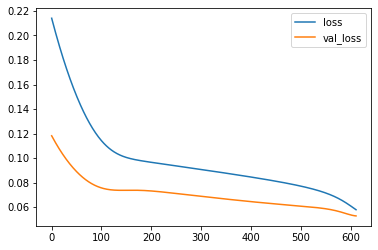

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    batch_size = 24,                    # Train set's 1~2%, current = 1~2%
                    epochs = 612,                       # Train set's 10%, current = 20%
                    verbose = 1,                        # 0=silent, 1=progress bar, 2=one line per epoch.
                    )

# loss and acc graph (train nd val)
history_df = pd.DataFrame(history.history)
history_df[["loss", "val_loss"]].plot()

# Acc and Loss about real data
learning_lost, learning_err = model.evaluate(X_test, y_test, verbose=2)
print("Learning error % :", learning_err * 100)
print("Learning loss % :", learning_lost * 100)

### Load model

In [11]:
#model = load_model('PPoA_onion.h5')

### Prediction

In [38]:
pred_res = model.predict(pred_X_dataset)

pred_min_price = Denormalization_min(ori_prices, pred_res)
for idx, price in enumerate(pred_min_price) : pred_min_price[idx] = round(price[0])
pred_max_price = Denormalization_max(ori_prices, pred_res)
for idx, price in enumerate(pred_max_price) : pred_max_price[idx] = round(price[0])
pred_avg_price = Denormalization_avg(ori_prices, pred_res)
for idx, price in enumerate(pred_avg_price) : pred_avg_price[idx] = round(price[0])
    
price_June = {}
price_Dec = {}
for idx in range(0, 2) :
    min = pred_min_price[idx].astype(int)[0]
    avg = pred_avg_price[idx].astype(int)[0]
    max = pred_max_price[idx].astype(int)[0]
    if idx == 0 :
        price_June['최저가'] = min
        price_June['평균가'] = avg
        price_June['최고가'] = max
    else :
        price_Dec['최저가'] = min
        price_Dec['평균가'] = avg
        price_Dec['최고가'] = max

for scale, price in price_June.items() :
    print("6월달 예상 "+ scale +" = ", price)
print('----------------------------')
for scale, price in price_Dec.items() :
    print("12월달 예상 "+ scale +" = ", price)
print('----------------------------')
for idx, price in enumerate(pred_y_dataset.tolist()) :
    if idx == 0 : print("실제 6월 양파 가격 = ", price[0])
    else : print("실제 12월 양파 가격 = ", price[0])

6월달 예상 최저가 =  686
6월달 예상 평균가 =  1014
6월달 예상 최고가 =  1342
----------------------------
12월달 예상 최저가 =  881
12월달 예상 평균가 =  1209
12월달 예상 최고가 =  1537
----------------------------
실제 6월 양파 가격 =  569
실제 12월 양파 가격 =  1225


### Model save

In [13]:
#model.save('PPoA_onion.h5')